In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from scipy import stats, interpolate
import tqdm
import caveclient
import collections
import itertools

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 

In [2]:
import os
import sys

HOME = os.path.expanduser("~")

# NOTE: adjust for your system
data_dir = f"{HOME}/SWDB_2025_Connectomics/data/"
utils_dir = f"{HOME}/SWDB_2025_Connectomics/code/utils"

In [3]:
from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis.drifting_gratings import DriftingGratings
from allen_v1dd.stimulus_analysis.natural_images import NaturalImages
from allen_v1dd.stimulus_analysis.natural_movie import NaturalMovie

base_folder = f"{HOME}/V1DDAnalysis/func_data"
ophys_client = OPhysClient(base_folder)

## Coregistration information

In [4]:
mat_version = 1196
client = caveclient.CAVEclient(
    "v1dd", server_address="https://global.em.brain.allentech.org", version=mat_version
)

In [5]:
coreg_df = client.materialize.query_table("functional_coregistration_manual_2")

In [6]:
coreg_df[["pt_root_id", "column", "volume", "plane", "roi"]].to_feather(f"{data_dir}/coregistration_{mat_version}.feather", compression="zstd")

## Pairwice trace correlations by stimulus type

In [7]:
def get_aligned_session_data(column, volume, remove_known_bad_planes=True, mouse_id=409828):
    planes = range(6)
    if remove_known_bad_planes:
        if column == 1 and volume == 5:
            planes = range(5)
    
    sess = ophys_client.load_ophys_session(mouse=mouse_id, column=column, volume=volume)
    
    dff_traces = []
    rois_traces = []
    planes_traces = []
    
    base_times = np.array(sess.get_traces(plane=0, trace_type="dff").time)
    for plane in planes:
        traces_xarray = sess.get_traces(plane=plane, trace_type="dff", valid_only=True)
        f_interp = interpolate.interp1d(traces_xarray.time, traces_xarray.data, 
                            kind='linear', axis=1, bounds_error=False, fill_value="extrapolate")
        
        dff_traces.extend(f_interp(base_times))
        rois_traces.extend(traces_xarray.roi)
        planes_traces.extend([plane] * len(traces_xarray.roi))
        
    dff_traces = np.array(dff_traces)
    planes_traces = np.array(planes_traces)
    rois_traces = np.array(rois_traces)
    
    return {
        "dff": dff_traces,
        "plane": planes_traces,
        "roi": rois_traces,
        "base_time": base_times,
    }


def get_stimulus_sections(stim_table, threshold=1.1):
    # Convert start and end to NumPy arrays
    starts = stim_table["start"].values
    ends = stim_table["end"].values
    
    # Compute gaps between consecutive end/start
    gaps = starts[1:] - ends[:-1]
    
    # Find where gaps exceed threshold → discontinuity
    discontinuity_indices = np.where(gaps >= threshold)[0] + 1
    
    # Add start and end anchors
    split_indices = np.concatenate(([0], discontinuity_indices, [len(stim_table)]))
    
    # Collect sections
    sections = [(starts[i], ends[j - 1]) for i, j in zip(split_indices[:-1], split_indices[1:])]
    return sections


def get_stimulus_mask(sections, base_times):
    # Initialize mask with False
    mask = np.zeros_like(base_times, dtype=bool)
    
    # For each section, mark time points that fall within the interval
    for start, end in sections:
        mask |= (base_times >= start) & (base_times <= end)

    return mask


def get_combined_stimulus_map(column, volume, mouse_id=409828):
    sess = ophys_client.load_ophys_session(mouse=mouse_id, column=column, volume=volume)
    
    stim_list = sess.get_stim_list()
    stim_mask = np.zeros(len(session_data["base_time"]), dtype=int)
    stim_map = {}
    for i_stim, stim in enumerate(sess.get_stim_list()):
        stim_table = sess.get_stimulus_table(stim)[0]
        single_stim_mask = get_stimulus_mask(get_stimulus_sections(stim_table), session_data["base_time"])
        stim_mask[single_stim_mask] = i_stim + 1
        stim_map[i_stim + 1] = stim

    return stim_map, stim_mask

In [8]:
func_data_tuples = []
for column in coreg_df["column"].unique():
    for volume in coreg_df[coreg_df["column"] == column]["volume"].unique():
        if np.isnan(volume): continue
        func_data_tuples.append([column, int(volume)])

func_data_tuples

[[np.int64(1), 3], [np.int64(1), 5], [np.int64(2), 5]]

In [9]:
sess = ophys_client.load_ophys_session(mouse=409828, column=column, volume=volume)
stim_names = sess.get_stim_list()

In [10]:
corr_data = collections.defaultdict(list)
for column, volume in tqdm.tqdm(func_data_tuples):
    print(column, volume)
    session_data = get_aligned_session_data(column, volume, remove_known_bad_planes=True)
    stim_map, stim_mask = get_combined_stimulus_map(column, volume)

    corrs = {}
    for i_stim in stim_map: 
        corr_matrix = np.corrcoef(session_data["dff"][:, stim_mask == i_stim])
        corrs[stim_map[i_stim]] = corr_matrix.flatten()
        
    pairwise_rois = np.array(list(itertools.product(session_data["roi"], session_data["roi"])))
    pairwise_planes = np.array(list(itertools.product(session_data["plane"], session_data["plane"])))
    corr_data["pre_roi"].extend(pairwise_rois[:, 0])
    corr_data["post_roi"].extend(pairwise_rois[:, 1])
    corr_data["pre_plane"].extend(pairwise_planes[:, 0])
    corr_data["post_plane"].extend(pairwise_planes[:, 1])
    corr_data["column"].extend([column] * len(pairwise_rois))
    corr_data["volume"].extend([volume] * len(pairwise_rois))
    for stim in corrs:
        corr_data[stim].extend(corrs[stim])

corr_df = pd.DataFrame(corr_data)
corr_df = corr_df[corr_df["pre_roi"] != corr_df["post_roi"]].reset_index(drop=True)

  0%|                                                       | 0/3 [00:00<?, ?it/s]

1 3


 33%|███████████████▋                               | 1/3 [00:10<00:21, 10.93s/it]

1 5


 67%|███████████████████████████████▎               | 2/3 [00:16<00:07,  7.77s/it]

2 5


100%|███████████████████████████████████████████████| 3/3 [00:18<00:00,  6.27s/it]


In [11]:
corr_df.to_feather(f"{data_dir}/cell_cell_correlations_by_stimulus.feather", compression="zstd")

In [12]:
corr_coreg_df = corr_df.copy()
corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"pre_roi": "roi", "pre_plane": "plane"}), 
                         coreg_df.rename(columns={"pt_root_id": "pre_pt_root_id"}), 
                         on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "pre_roi", "plane": "pre_plane"})

corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"post_roi": "roi", "post_plane": "plane"}), 
                         coreg_df.rename(columns={"pt_root_id": "post_pt_root_id"}), 
                         on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "post_roi", "plane": "post_plane"})

In [13]:
corr_coreg_df[["pre_pt_root_id", "post_pt_root_id"] + list(corr_df.columns[6:])].to_feather(f"{data_dir}/cell_cell_correlations_by_stimulus_coregistered.feather", compression="zstd")

In [339]:
stim_stim_corr = collections.defaultdict(list)
for stim_name_a in stim_names:
    for stim_name_b in stim_names:
        stim_stim_corr["A"].append(stim_name_a)
        stim_stim_corr["B"].append(stim_name_b)
        stim_stim_corr["corr"].append(stats.pearsonr(corr_df[stim_name_a], corr_df[stim_name_b])[0])

stim_stim_corr_df = pd.DataFrame(stim_stim_corr)

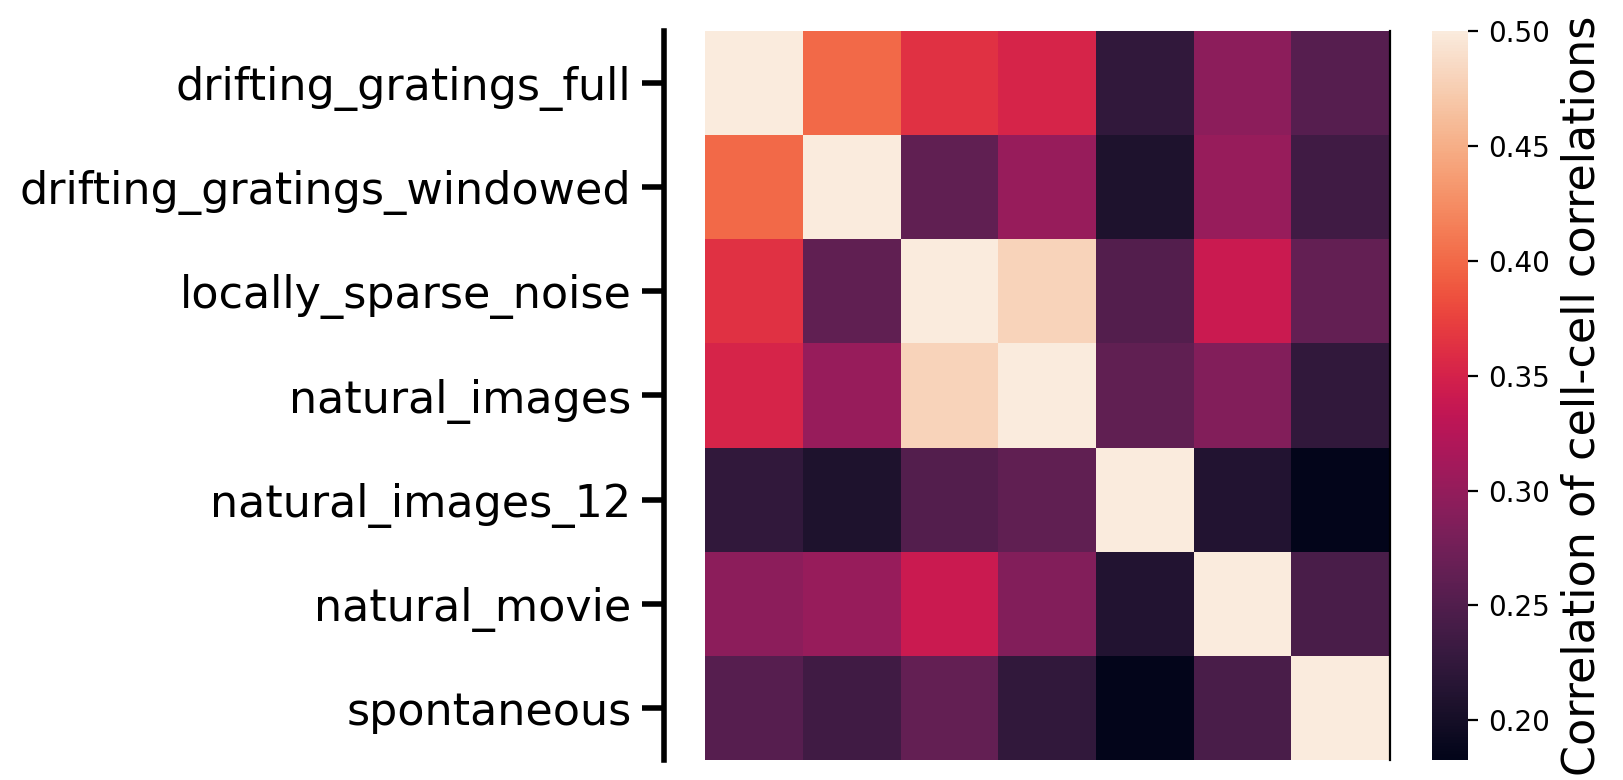

In [363]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

heatmap = sns.heatmap(stim_stim_corr_df.pivot(index="A", columns="B", values="corr"), ax=ax, vmax=.5)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Correlation of cell-cell correlations", fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

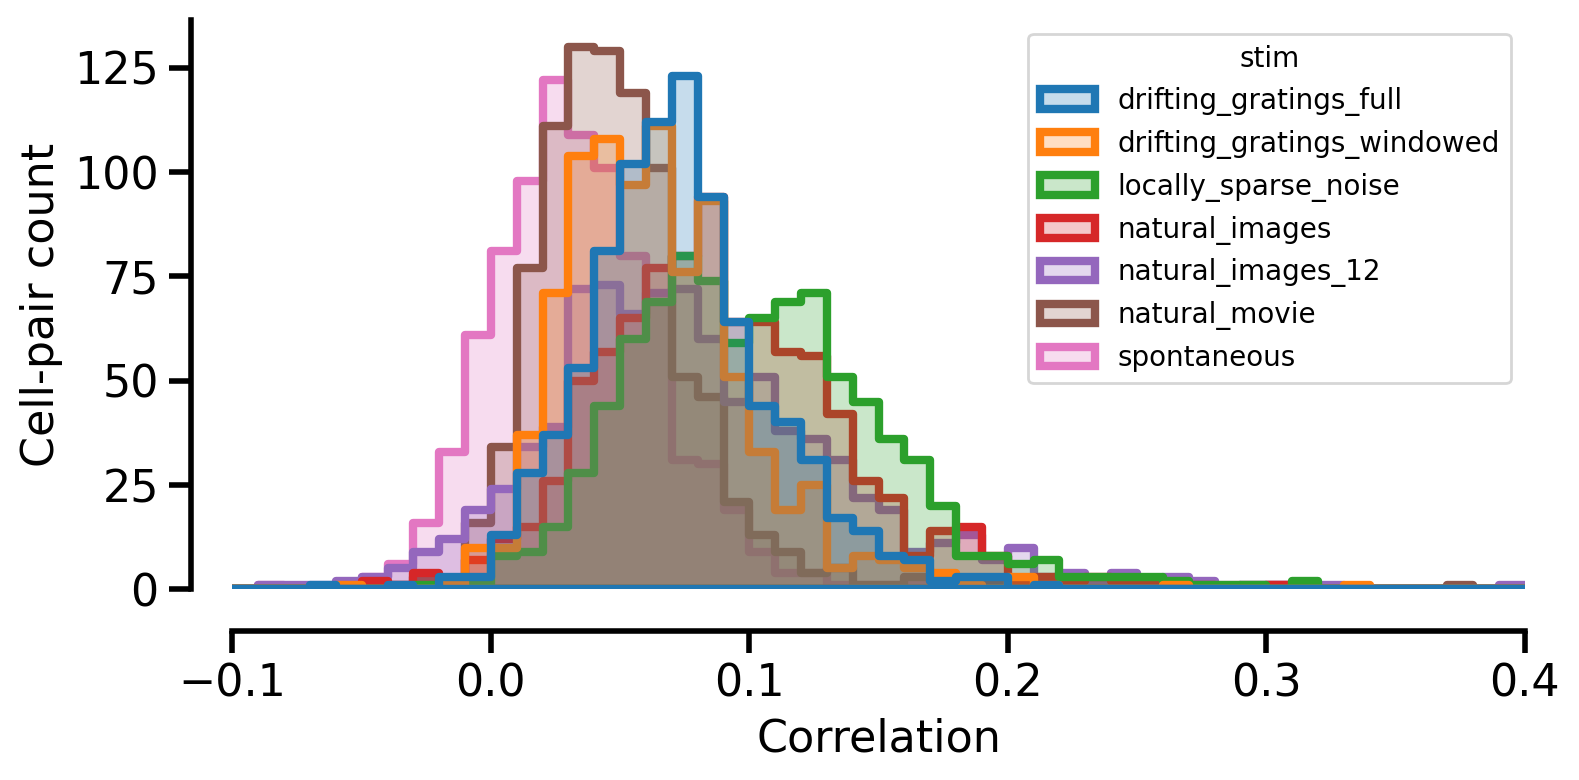

In [234]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

sns.histplot(data=corr_df.iloc[::10000], x="corr_r", hue="stim", bins=np.linspace(-1, 1, 201), element="step", lw=3, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine
ax.set_xlim(-.1, .4)

# ax.set_yscale("log")

ax.set_xlabel("Correlation", fontsize=16)
ax.set_ylabel("Cell-pair count", fontsize=16)
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

## Estimating SNR

In [486]:
def estimate_snr_white_noise_model(data, fs=6.0, signal_band=(0.1, 1.5), noise_band=(2., 2.1)):
    """
    Estimate SNR for each neuron's trace based on power in signal band vs noise from a defined noise band.

    Parameters:
    - data: ndarray (n_cells, n_timepoints)
    - fs: sampling rate in Hz
    - signal_band: tuple (f_low, f_high) in Hz
    - noise_band: tuple (f_low, f_high) in Hz

    Returns:
    - snr: ndarray of shape (n_cells,)
    - freqs: 1D ndarray of frequency bins
    - power_spectrum: 2D ndarray (n_cells, n_freqs)
    - signal_power: 1D ndarray of total signal-band power
    - noise_power_scaled: 1D ndarray of estimated white noise power (scaled to signal band)
    """
    n_cells, n_timepoints = data.shape
    freqs = np.fft.rfftfreq(n_timepoints, d=1/fs)
    fft_vals = np.fft.rfft(data, axis=1)
    power_spectrum = np.abs(fft_vals)**2

    # Frequency masks
    signal_mask = (freqs >= signal_band[0]) & (freqs <= signal_band[1])
    noise_mask = (freqs >= noise_band[0]) & (freqs <= noise_band[1])

    # Compute signal and noise power
    signal_power = power_spectrum[:, signal_mask].sum(axis=1)
    noise_estimate_per_bin = power_spectrum[:, noise_mask].mean(axis=1)
    noise_power_scaled = noise_estimate_per_bin * signal_mask.sum()  # scale noise to signal band width

    # Final SNR
    snr = signal_power / (noise_power_scaled + 1e-12)

    return snr, freqs, power_spectrum, signal_power, noise_power_scaled

In [487]:
session_data = get_aligned_session_data(column, volume, remove_known_bad_planes=True)

In [500]:
snr_dfs = []

for column, volume in tqdm.tqdm(func_data_tuples):
    session_data = get_aligned_session_data(column, volume, remove_known_bad_planes=True)
    snr, freqs, power_spectrum, signal_power, noise_power_scaled = estimate_snr_white_noise_model(session_data["dff"])
    snr_dfs.append(pd.DataFrame({"column": column, "volume": volume, "plane": session_data["plane"], "roi": session_data["roi"], "snr": snr}))
    break
snr_df = pd.concat(snr_dfs)

  0%|                                                       | 0/3 [00:05<?, ?it/s]


In [501]:
snr_df.to_feather(f"{data_dir}/snr_by_cell.feather", compression="zstd")

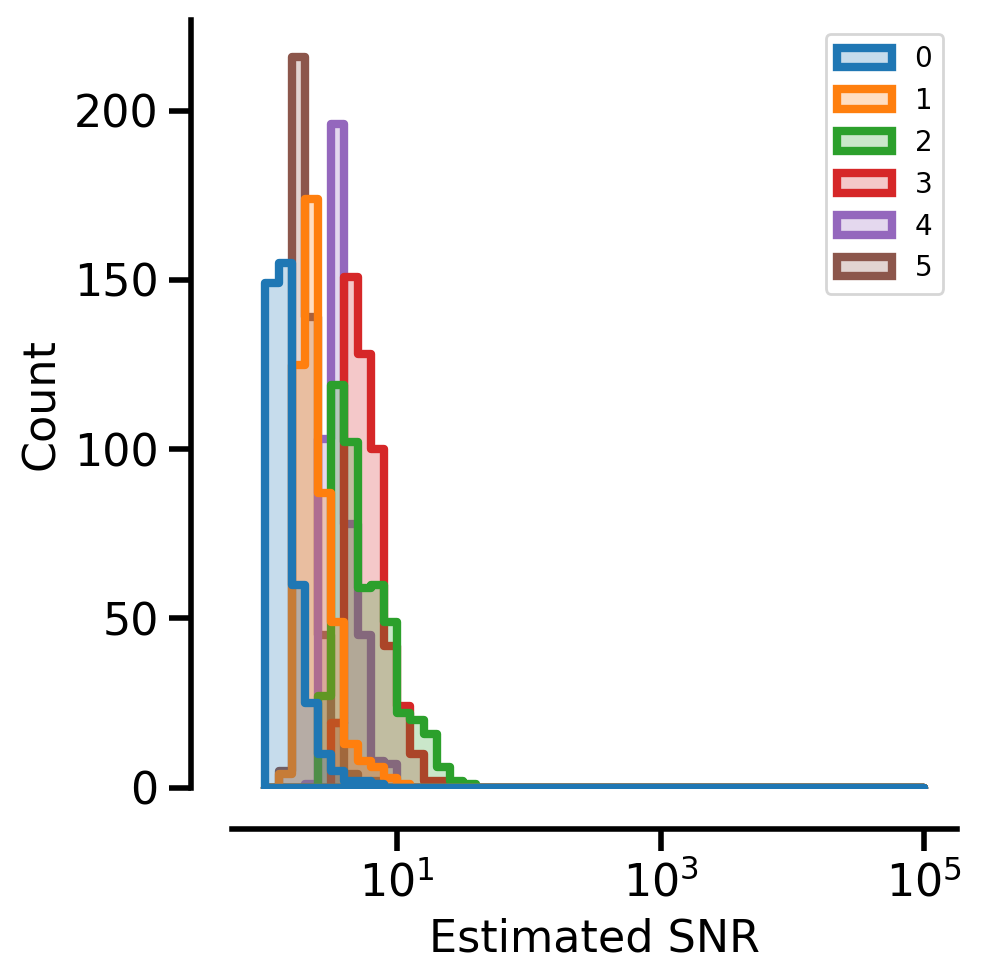

In [502]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
sns.histplot(x=snr, hue=session_data["plane"], palette="tab10", bins=np.logspace(0, 5, 51), element="step", lw=3, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("Estimated SNR", fontsize=16)
ax.set_ylabel("Count", fontsize=16)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

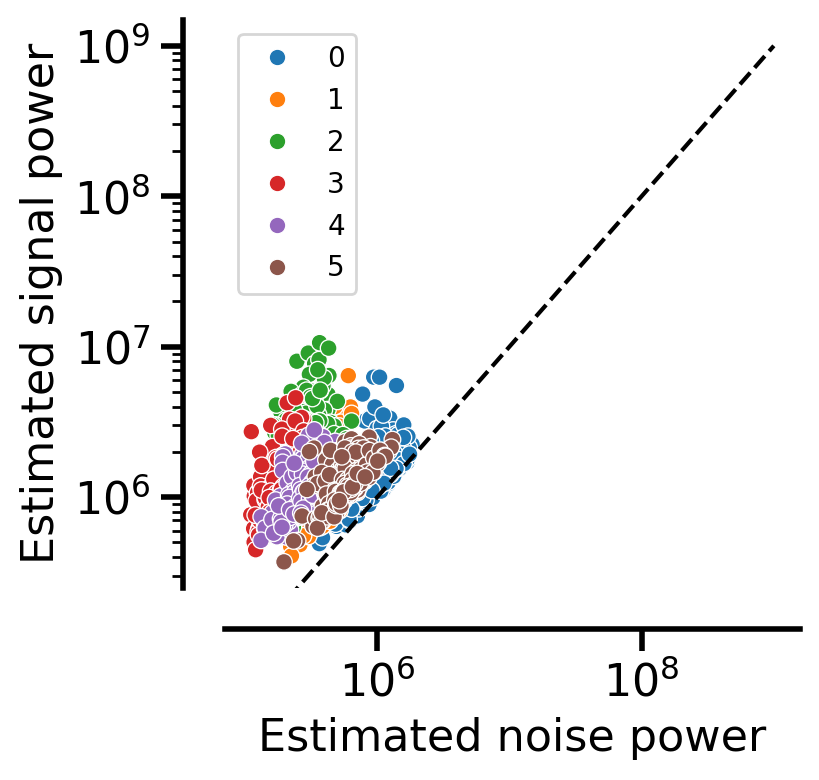

In [503]:
fig, ax = plt.subplots(figsize=(4.2, 4), dpi=200)

sns.scatterplot(x=noise_power_scaled, y=signal_power, hue=session_data["plane"], palette="tab10")
ax.plot((0, 1e9), (0, 1e9), ls="--", c="k")

ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels



ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Estimated noise power", fontsize=16)
ax.set_ylabel("Estimated signal power", fontsize=16)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/2616758846.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)
/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/2616758846.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)
/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/2616758846.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)
/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/2616758846.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), pale

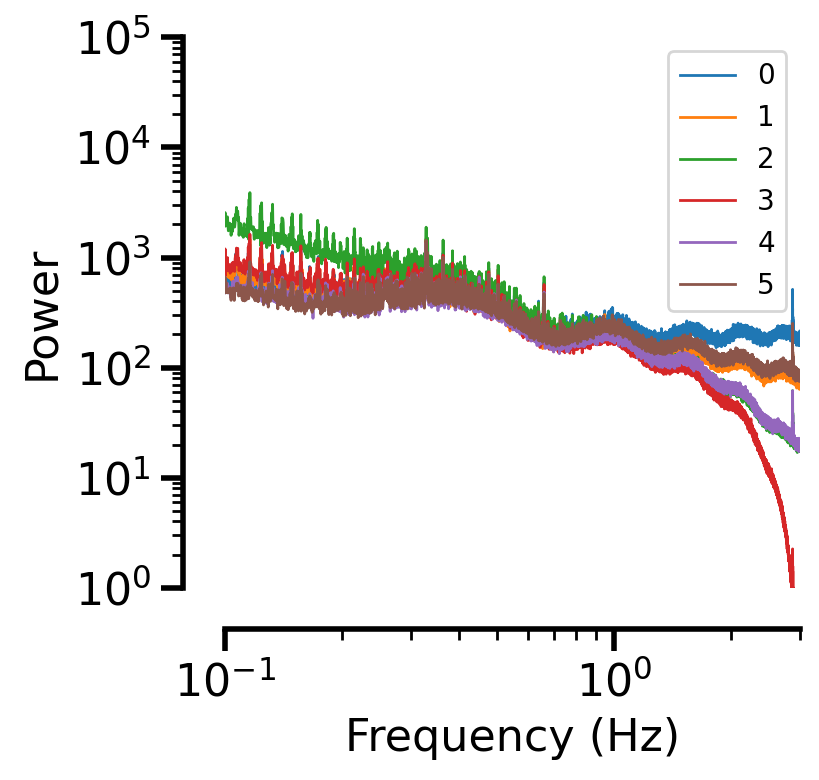

In [504]:
fig, ax = plt.subplots(figsize=(4.2, 4), dpi=200)

for plane in np.unique(session_data["plane"]):
    # if plane != 3: continue
    plane_m = session_data["plane"] == plane
    sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)
# ax.plot((0, 1e9), (0, 1e9), ls="--", c="k")

ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels



ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Frequency (Hz)", fontsize=16)
ax.set_ylabel("Power", fontsize=16)
ax.set_xlim(.1, 3)
ax.set_ylim(1, 1e5)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/3786645269.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)


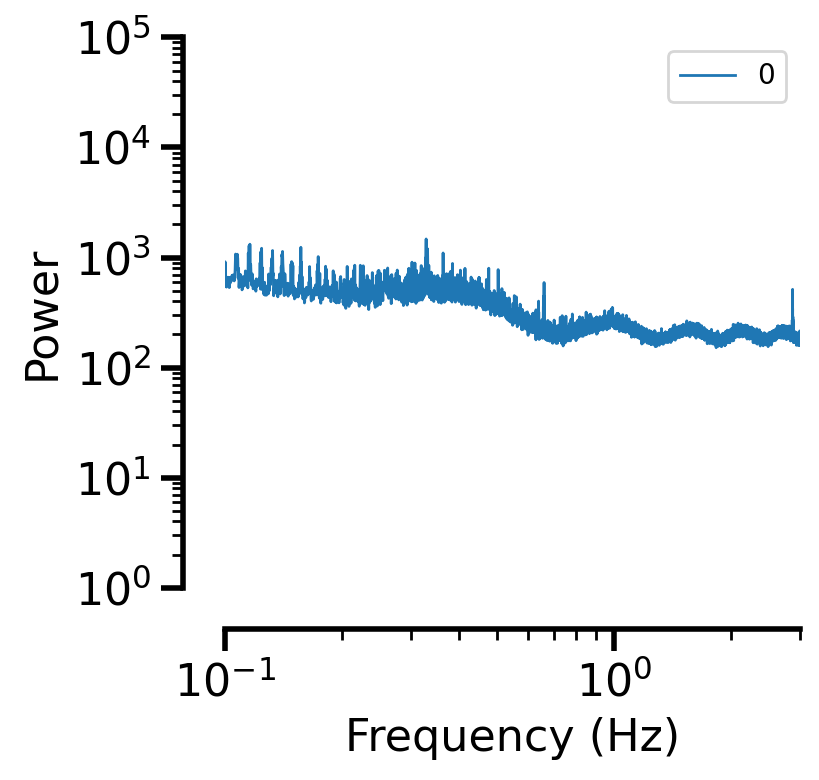

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/3786645269.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)


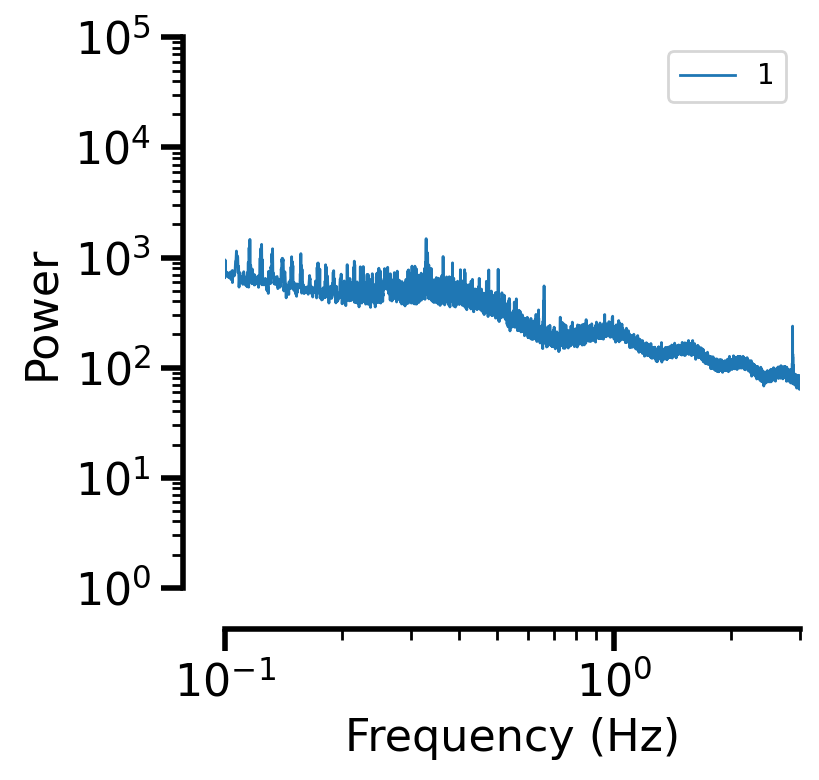

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/3786645269.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)


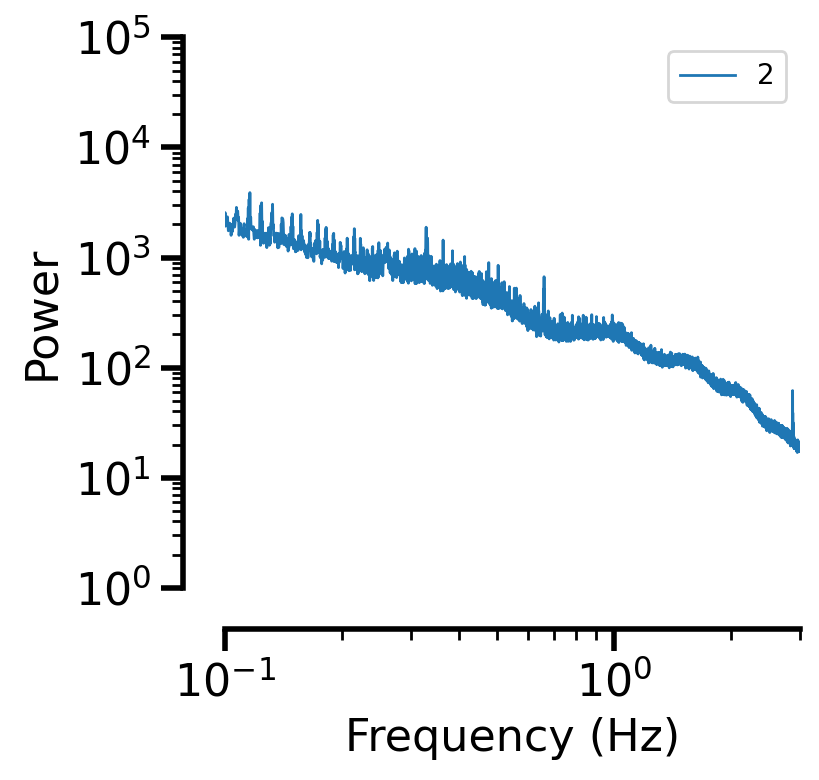

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/3786645269.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)


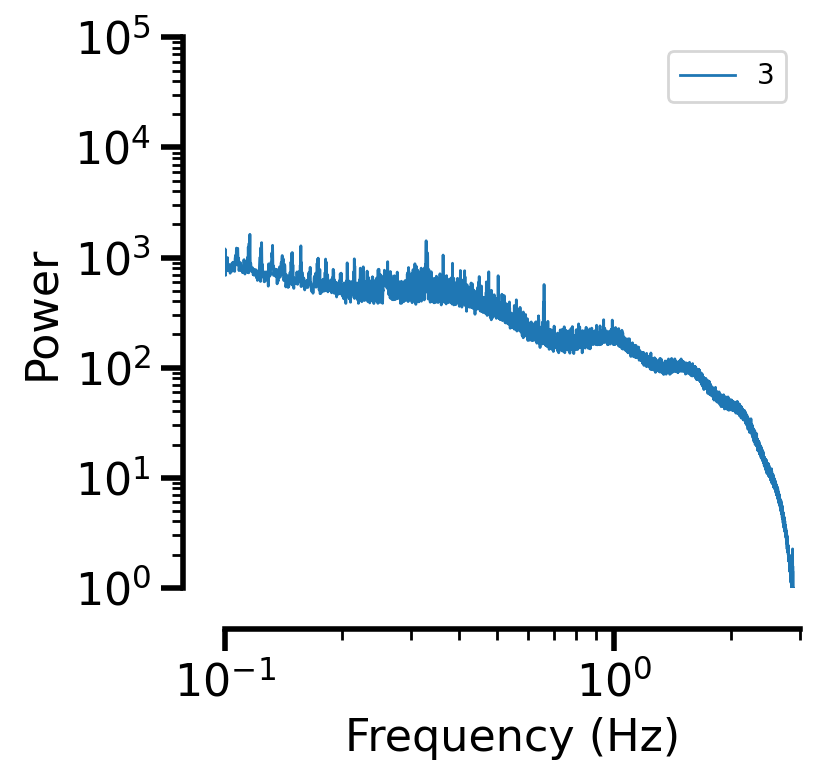

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/3786645269.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)


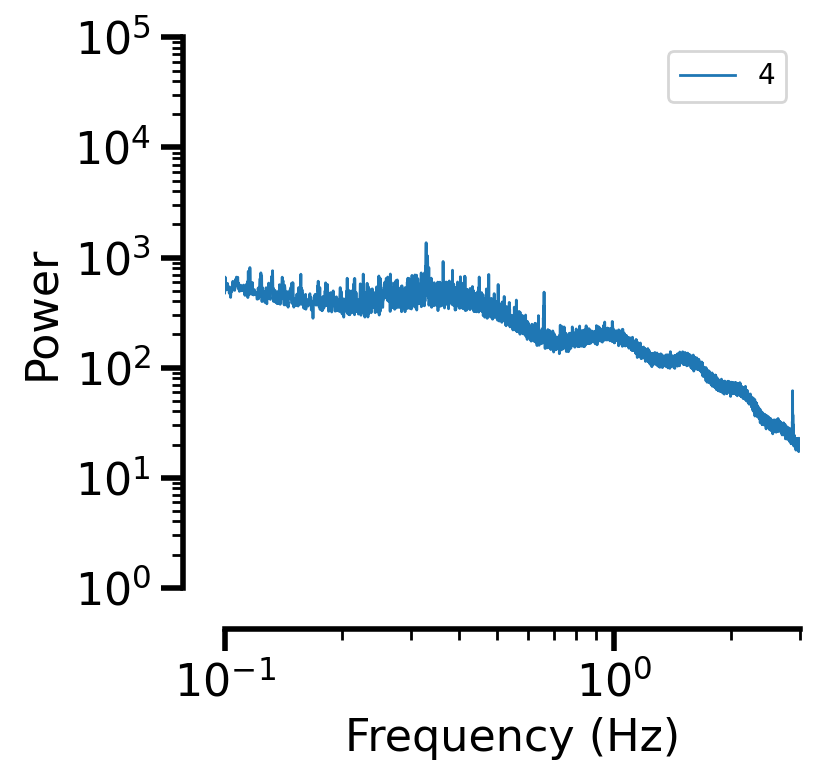

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_9964/3786645269.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)


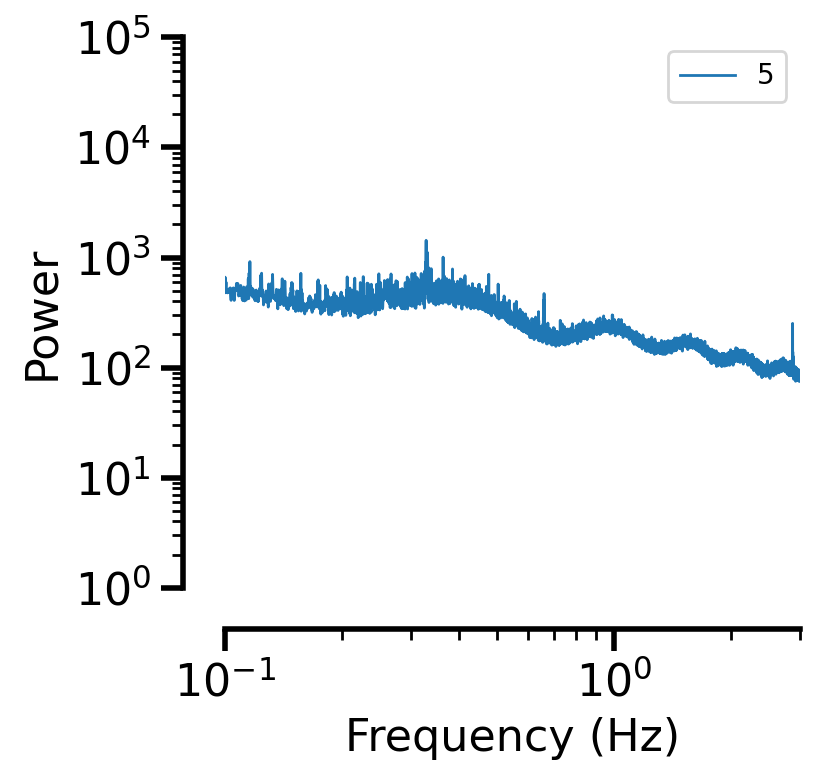

In [505]:
for plane in np.unique(session_data["plane"]):
    # if plane != 3: continue
    plane_m = session_data["plane"] == plane
    
    fig, ax = plt.subplots(figsize=(4.2, 4), dpi=200)


    sns.lineplot(x=freqs, y=power_spectrum[plane_m].mean(axis=0), palette="tab10", lw=1, label=plane)
    # ax.plot((0, 1e9), (0, 1e9), ls="--", c="k")
    
    ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
    ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels
    
    
    
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
    ax.spines['left'].set_linewidth(2)  # Hide the right spine
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_xlabel("Frequency (Hz)", fontsize=16)
    ax.set_ylabel("Power", fontsize=16)
    ax.set_xlim(.1, 3)
    ax.set_ylim(1, 1e5)
    
    sns.despine(offset=15, trim=False)
    plt.tight_layout()
    plt.show()